# Lecture 9 - Production Planning

## Header

In [1]:
# # Dependencies: Uncomment and run this cell if you don't have these packages 
# using Pkg
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Plots")

In [2]:
include("src/data.jl");
include("src/opt.jl");
include("src/out.jl");

## Data Input

We'll use Gurobi, but you can subsitute your own optimizer here.

In [3]:
env = Gurobi.Env()
optimizer = () -> Gurobi.Optimizer(env);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-18


Generate instance data.

In [4]:
n_periods = 20
unit_cost = 1.0
holding_cost = 1.0
fixed_cost = 50.0
dat = ProductionInstance(n_periods, unit_cost, holding_cost, fixed_cost)

Production Planning Instance with 20 periods

## Base IP

First, we build the base model, solve it, and plot the production plan.

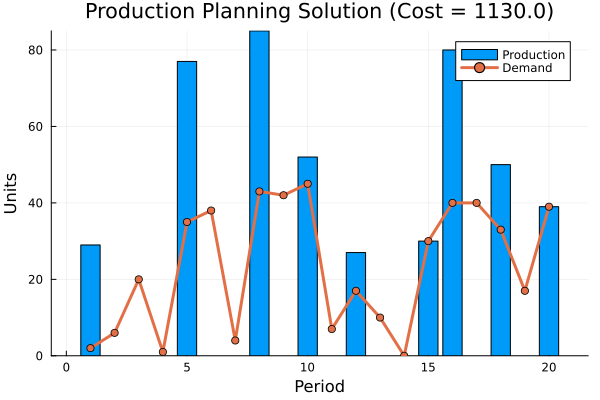

In [5]:
mdl = ProductionModel(dat, optimizer = optimizer, silent = true)
solution = solve!(mdl)
plot_plan(solution)

## LP Relaxation

Now we'll take a look at the LP relaxation. The basic formulation has a big integrality gap...

In [6]:
mdl_lp = ProductionModel(dat, optimizer = optimizer, silent = true)
JuMP.relax_integrality(mdl_lp.model)
solution_lp = solve!(mdl_lp)
println("LP Objective Value:\t", round(solution_lp.objective_value, digits=2))
println("IP Objective Value:\t", round(solution.objective_value, digits=2))

LP Objective Value:	519.0
IP Objective Value:	1130.0


What does the solution look like? We're producing in every period...

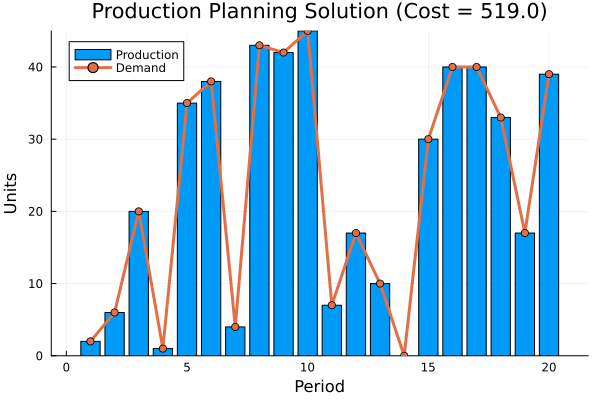

In [7]:
plot_plan(solution_lp)

The Big-M constraint gives us a weak formulation. We can see this by looking at the values of the binary variables indicating whether we produce or not in a given period, which match the values of the production variables divided by the Big-M value.

In [8]:
M = sum(dat.demand)
println("y values:\t", round.(JuMP.value.(mdl_lp.do_produce), digits=3))
println()
println("x/M values:\t", round.(JuMP.value.(mdl_lp.production) ./ sum(dat.demand), digits=3))

y values:	[0.004, 0.013, 0.043, 0.002, 0.075, 0.081, 0.009, 0.092, 0.09, 0.096, 0.015, 0.036, 0.021, 0.0, 0.064, 0.085, 0.085, 0.07, 0.036, 0.083]

x/M values:	[0.004, 0.013, 0.043, 0.002, 0.075, 0.081, 0.009, 0.092, 0.09, 0.096, 0.015, 0.036, 0.021, 0.0, 0.064, 0.085, 0.085, 0.07, 0.036, 0.083]


## Extended Formulation

Now we'll try the extended formulation. The extended formulation is tight!

In [9]:
# Build the extended formulation
mdl_ef = ProductionModel(dat, optimizer = optimizer, silent = true)
extend_formulation!(mdl_ef) # Adds the auxiliary variables and constraints
JuMP.relax_integrality(mdl_ef.model)
solution_ef = solve!(mdl_ef)

# Solve and compare the objective values
solution_ef = solve!(mdl)
println("EF-LP Objective Value:\t", round(solution_ef.objective_value, digits=2))
println("IP Objective Value:\t", round(solution.objective_value, digits=2))

EF-LP Objective Value:	1130.0
IP Objective Value:	1130.0
